### Importing Libraries

In [ ]:
!pip install nltk #Natural Language Toolkit
!pip install demoji #Used for converting emojis into text.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 675.7 kB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import demoji
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

### Importing Dataset

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Project 1/Dataset/cyberbullying_tweets.csv')

### Exploratory Data Analysis

In [ ]:
dataset.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [ ]:
dataset.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [ ]:
#There are no null values in the dataset

In [ ]:
dataset.shape

(47692, 2)

In [ ]:
dataset.describe()

,tweet_text,cyberbullying_type
count,47692,47692
unique,46017,6
top,RT @sailorhg: the intro for my hardware hackin...,religion
freq,2,7998


In [ ]:
dataset.columns

Index(['tweet_text', 'cyberbullying_type'], dtype='object')

In [ ]:
dataset['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

In [ ]:
#The cyberbullying_type is equally split as we can see from the above data.

In [ ]:
dataset.duplicated().sum()

36

In [ ]:
dataset.drop_duplicates(subset='tweet_text',keep='first',inplace=True)

In [ ]:
dataset.shape

(46017, 2)

### Encoding cyberbullying_type in the dataset

In [ ]:
ENCODE_DICT = {'not_cyberbullying': 0,
             'gender': 1,
             'religion': 2,
             'other_cyberbullying': 3,
             'age': 4,
             'ethnicity': 5}
dataset['cyberbullying_type'] = dataset.cyberbullying_type.replace(ENCODE_DICT)
print(dataset.cyberbullying_type.unique())

[0 1 2 3 4 5]


In [ ]:
dataset.sample(5)

,tweet_text,cyberbullying_type
19452,We as Catholics/ Christians cannot stand idle ...,2
30101,@realDonaldTrump What were you doing during th...,3
13713,@SumbelinaZ @TIB2016 @IronmanL1 @Hatewatch You...,1
41825,.. shut up paige you sound very dumb!!! They t...,5
46577,I love U for getting the wrong idea. Don't get...,5


### Data Cleaning

In [ ]:
def cleantext(text):

  #Removal of hashtags, mentions, urls and retweets
  pattern = re.compile(r"(#[A-Za-z0-9]+|@[A-Za-z0-9]+|https?://\S+|www\.\S+|\S+\.[a-z]+|RT @)")
  text = pattern.sub('', text)

  #Removal of multiple spaces between words and rejoining using single space
  text = " ".join(text.split())

  #Lemmatize each word in the tweet
  #Lemmatization is the process of reducing words to their base or dictionary form, called the lemma.
  lemma = WordNetLemmatizer()
  text = " ".join([lemma.lemmatize(word) for word in text.split()])

  #Instead of removing the emoji, we convert the emoji in the tweet to text and add it back to the tweet
  emoji = demoji.findall(text)
  for emot in emoji:
      text = re.sub(r"(%s)" % (emot), "_".join(emoji[emot].split()), text)

  #Expansion of contractions
  contractions = {
        r"can\'t": "can not",
        r"n\'t": " not",
        r"\'re": " are",
        r"\'s": " is",
        r"\'d": " would",
        r"\'ll": " will",
        r"\'ve": " have",
        r"\'m": " am"
    }
  for contraction, expansion in contractions.items():
        text = re.sub(contraction, expansion, text)

  #Stopwords are commonly used words (e.g., "a", "the", "is") that do not carry significant meaning. Thus stopwords are removed.
  STOPWORDS = set(stopwords.words('english'))
  text = " ".join([word for word in str(text).split() if word not in STOPWORDS])

  #Remove special characters keep only text
  text = re.sub(r'[^a-zA-Z\s]', '', text)

  return text

In [ ]:
dataset['cleaned_tweet_text'] = dataset.tweet_text.apply(lambda text: cleantext(text))

In [ ]:
dataset.sample(5)

,tweet_text,cyberbullying_type,cleaned_tweet_text
22634,@dankmtl What does that have to do with Muslim...,2,What doe Muslim extermination Jews
26905,I'm always being bullied =(,3,I always bullied
22358,You are an idiot.Death has no time for anyone....,2,You idiotDeath ha time anyone You die tomorrow...
40778,Fuck off linking me nightcore you dumb niggers,5,Fuck linking nightcore dumb nigger
20607,@98Halima @johnnygjokaj @BilalIGhumman @cdnKha...,2,ISIS want control world Mohammed wanted contro...


### Finding and Removing Duplicates

In [ ]:
dataset["cleaned_tweet_text"].duplicated().sum()

937

In [ ]:
dataset.drop_duplicates("cleaned_tweet_text", inplace=True)

In [ ]:
dataset.shape

(45080, 3)

### Splitting the dataset

In [ ]:
#Splitting into training and testing data
X = dataset['cleaned_tweet_text']
y = dataset['cyberbullying_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(36064,) (36064,) (9016,) (9016,)


In [ ]:
vectorizer = TfidfVectorizer()

X_train_tf = vectorizer.fit_transform(X_train)
X_test_tf = vectorizer.transform(X_test)

print(X_train_tf.shape)
print(X_test_tf.shape)

(36064, 39774)
(9016, 39774)


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_tf, y_train)

RandomForestClassifier()

In [ ]:
rf_pred = rf_clf.predict(X_test_tf)

In [ ]:
accuracy = accuracy_score(y_test, rf_pred)
print(accuracy)

0.8359582963620231


In [ ]:
classification_report = classification_report(y_test, rf_pred)
print(classification_report)

              precision    recall  f1-score   support

           0       0.60      0.69      0.64      1609
           1       0.89      0.82      0.85      1506
           2       0.95      0.96      0.95      1583
           3       0.57      0.51      0.54      1149
           4       0.98      0.98      0.98      1611
           5       0.98      0.98      0.98      1558

    accuracy                           0.84      9016
   macro avg       0.83      0.82      0.82      9016
weighted avg       0.84      0.84      0.84      9016



### RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [5,20,50,100],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'min_samples_split': [2, 6, 10],
    'min_samples_leaf': [1, 3, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

In [ ]:
rf_clf = RandomForestClassifier()

In [ ]:
random_search = RandomizedSearchCV(estimator=rf_clf,param_distributions=param_dist,n_iter=10,cv=5,scoring='accuracy',n_jobs=-1)

In [ ]:
random_search.fit(X_train_tf, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [5, 20, 50, 100]},
                   scoring='accuracy')

In [ ]:
best_params_random = random_search.best_params_
best_model_random = random_search.best_estimator_

In [ ]:
rf_pred_random = best_model_random.predict(X_test_tf)

In [ ]:
accuracy = accuracy_score(y_test, rf_pred_random)
print(accuracy)

0.8073425022182786


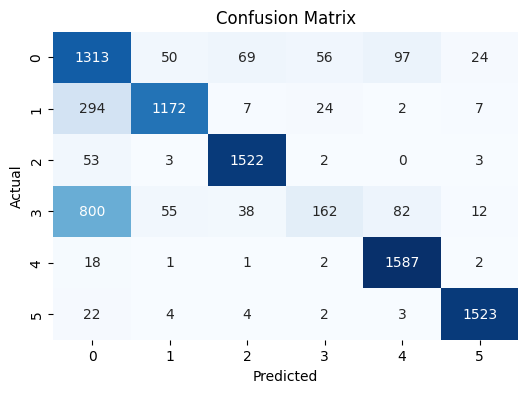

In [ ]:
rf_cm = confusion_matrix(y_test, rf_pred_random)
plt.figure(figsize=(6, 4))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()